# Transfer Learning on Sign Language Image Classification

The dataset of this notebook can be found at [Sign Language Gesture Images Dataset](https://www.kaggle.com/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/data)

## Imports

The following cells import the libraries needed for this project.

In [1]:
import tensorflow as tf
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
!curl -L -o 27-class-sign-language-dataset.zip https://www.kaggle.com/api/v1/datasets/download/ardamavi/27-class-sign-language-dataset
!unzip -oq 27-class-sign-language-dataset.zip -d "27-class-sign-language-dataset"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1083M  100 1083M    0     0   139M      0  0:00:07  0:00:07 --:--:--  163M


## Load Dataset

The dataset is structured into two `numpy` files.

We __normalize__ the dataset and split it into:

- train set (80%)
- validation set (10%)
- test set (10%)


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.load("/kaggle/working/27-class-sign-language-dataset/X.npy")
Y = np.load("/kaggle/working/27-class-sign-language-dataset/Y.npy")
Y = [str(label[0]) for label in Y]
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels to integers
Y = label_encoder.fit_transform(Y)

# Split the dataset into train, validation, test using sklearn
# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
# Step 2: Split the temp set into validation (10%) and test (20%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=42)

del X, Y

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_test: {X_val.shape}')

X_train: (15960, 128, 128, 3)
X_test: (4561, 128, 128, 3)
X_test: (2280, 128, 128, 3)


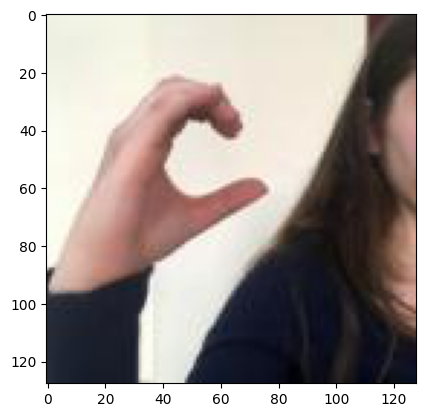

In [4]:
from matplotlib import pyplot as plt

plt.imshow(X_train[1])

In [5]:
# Now convert to keras dataset
# We will use the from_tensor_slices method

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(64)

def normalize_image(image, label):
    precomputed_mean = [0.5108343362808228, 0.47160401940345764, 0.43902790546417236]
    precomputed_std = [0.5867133736610413, 0.5466195344924927, 0.5143911242485046]
    
    # Resize the image
    image = tf.image.resize(image, (224, 224))
    # Normalize the image
    image = (image - precomputed_mean) / precomputed_std

    return image, label

# Apply normalization to the datasets
train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


# del X_train, Y_train, X_test, Y_test, X_val, Y_val

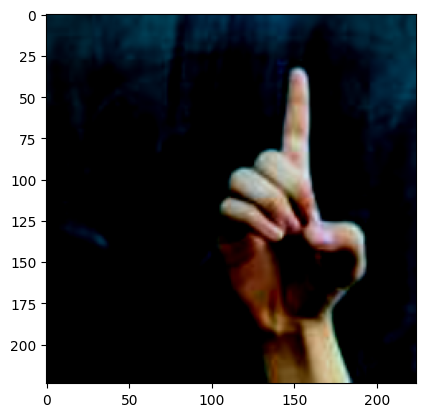

In [6]:
for images, labels in train_dataset:
    for image in images:
        # print(image.shape)
        plt.imshow(image )
    break

## Useful Methods

The following cells contain methods used to simplify the code

In [25]:
from sklearn.metrics import confusion_matrix

def get_class_count(dataset):
    class_counts = {}
    for images, labels in tqdm(dataset):
        for label in labels:
            # Here the label is a tensor with 1 element
            # We have to convert it to numpy
            label = label.numpy()
            # Count it
            class_counts[label] = class_counts.get(label, 0) + 1
    # Return the counts
    return class_counts

def plot_class_distribution(dataset, title: str):
    
    # Get the class counts
    class_counts = get_class_count(dataset)

    df = pd.DataFrame(class_counts, index=list(range(len(class_counts))))

    # Set the figure size
    plt.figure(figsize=(12, 6))
    # Add the data
    ax = sns.barplot(df)
    # Set the title
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    # Adjust layout to make room for rotated labels
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [32]:
def get_class_names(test_dataset, verbose: bool = False):
    class_names = set()

    for _, labels in tqdm(test_dataset, desc="Calculating class names"):
        for label in labels:
            class_names.add(int(label))

    if verbose:
        print(f"Unique Dataset Labels: {class_names}")

    return class_names

In [17]:
def plot_history(history):
    """Plot the loss and accuracy of the models."""
    
    # Convert the object to a DataFrame for easier access
    history_df = pd.DataFrame(history.history)

    # Set the style of seaborn
    sns.set(style='whitegrid')

    # Create a figure with a specific size
    plt.figure(figsize=(14, 6))

    #############
    # Loss plot #
    #############
    plt.subplot(1, 2, 1)
    sns.lineplot(data=history_df[['loss', 'val_loss']], palette='tab10', dashes=False, linewidth=2)
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train Loss', 'Validation Loss'], fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    #################
    # Accuracy plot #
    #################
    plt.subplot(1, 2, 2)
    sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], palette='tab10', dashes=False, linewidth=2)
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.legend(['Train Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


In [33]:
class_names = get_class_names(test_dataset=train_dataset)

class_names

Calculating class names: 100%|██████████| 250/250 [00:16<00:00, 15.60it/s]


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26}

## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 250/250 [00:17<00:00, 14.27it/s]


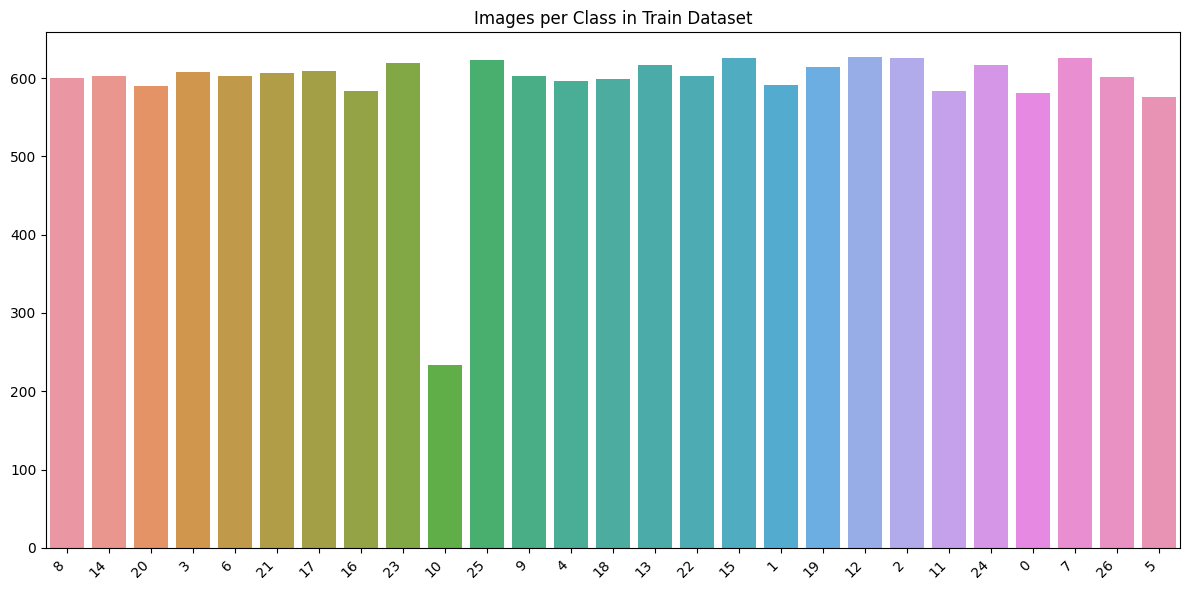

In [16]:
plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 36/36 [00:02<00:00, 12.04it/s]


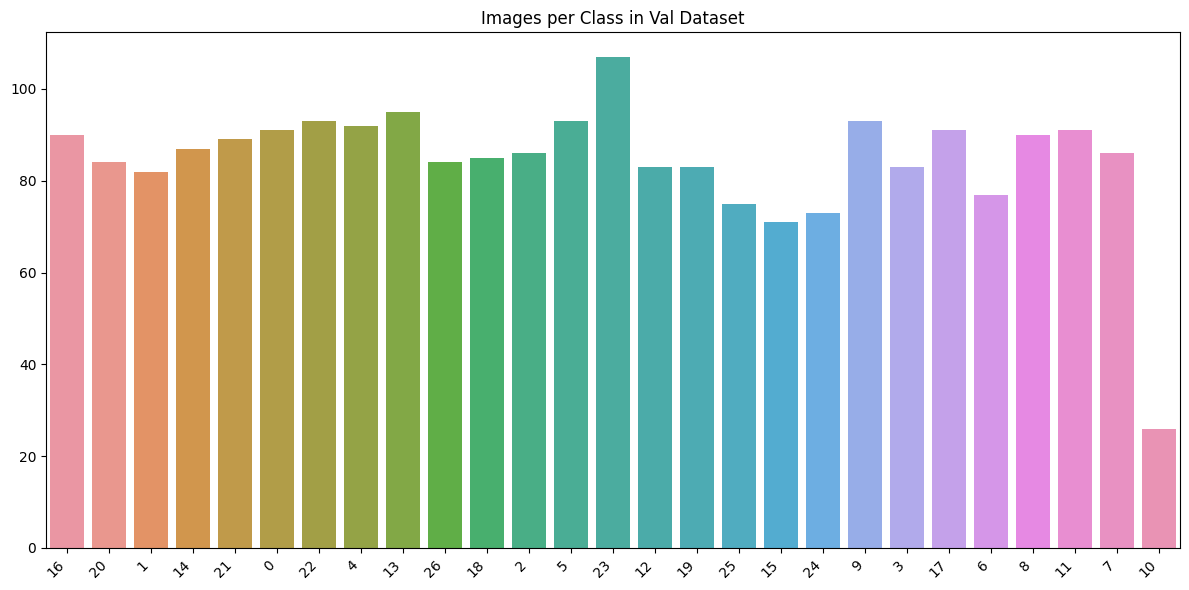

In [17]:
plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 72/72 [00:05<00:00, 12.29it/s]


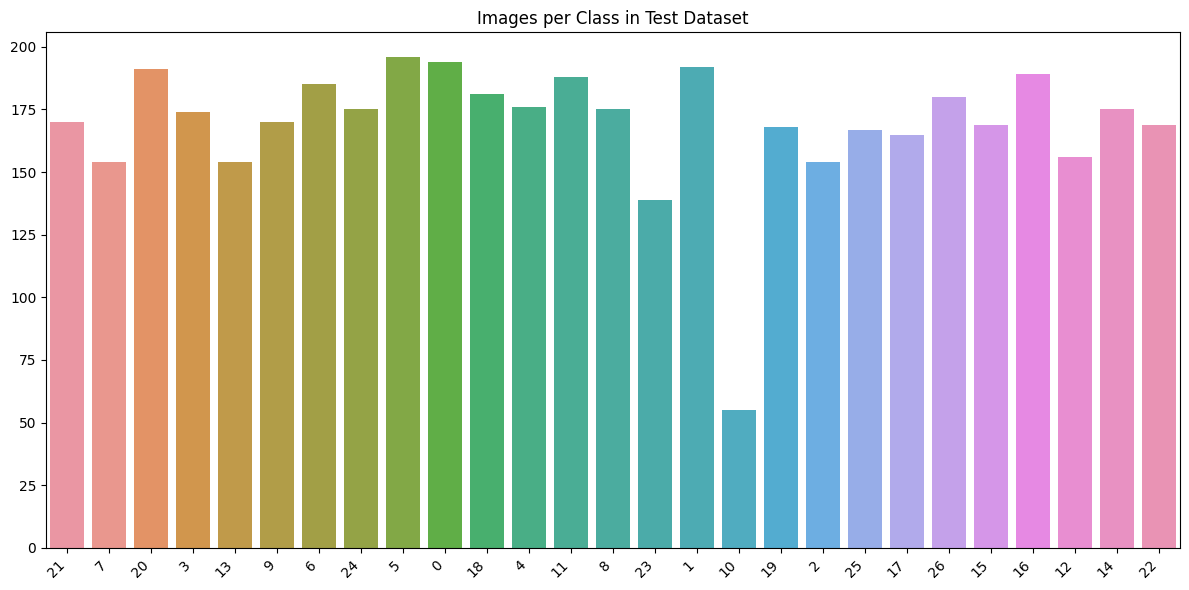

In [18]:
plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (50, 50, 3) to (96, 96, 3)

In [15]:
for images, labels in tqdm(test_dataset):
    NUM_CLASSES = len(labels)
    break

NUM_CLASSES

  0%|          | 0/72 [00:00<?, ?it/s]


64

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,425,947 (9.25 MB)

 Trainable params: 167,707 (655.11 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.3459 - loss: 2.3030 - val_accuracy: 0.6886 - val_loss: 1.0345
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.6888 - loss: 0.9931 - val_accuracy: 0.7610 - val_loss: 0.7785
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.7653 - loss: 0.7486 - val_accuracy: 0.7982 - val_loss: 0.6688
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8081 - loss: 0.5990 - val_accuracy: 0.8009 - val_loss: 0.6161
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.8399 - loss: 0.5084 - val_accuracy: 0.8140 - val_loss: 0.5644
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8577 - loss: 0.4398 - val_accuracy: 0.8171 - val_loss: 0.5580
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8745 - loss: 0.3868 - val_accuracy: 0.8237 - val_loss: 0.5290
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8893 - loss: 0.3

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

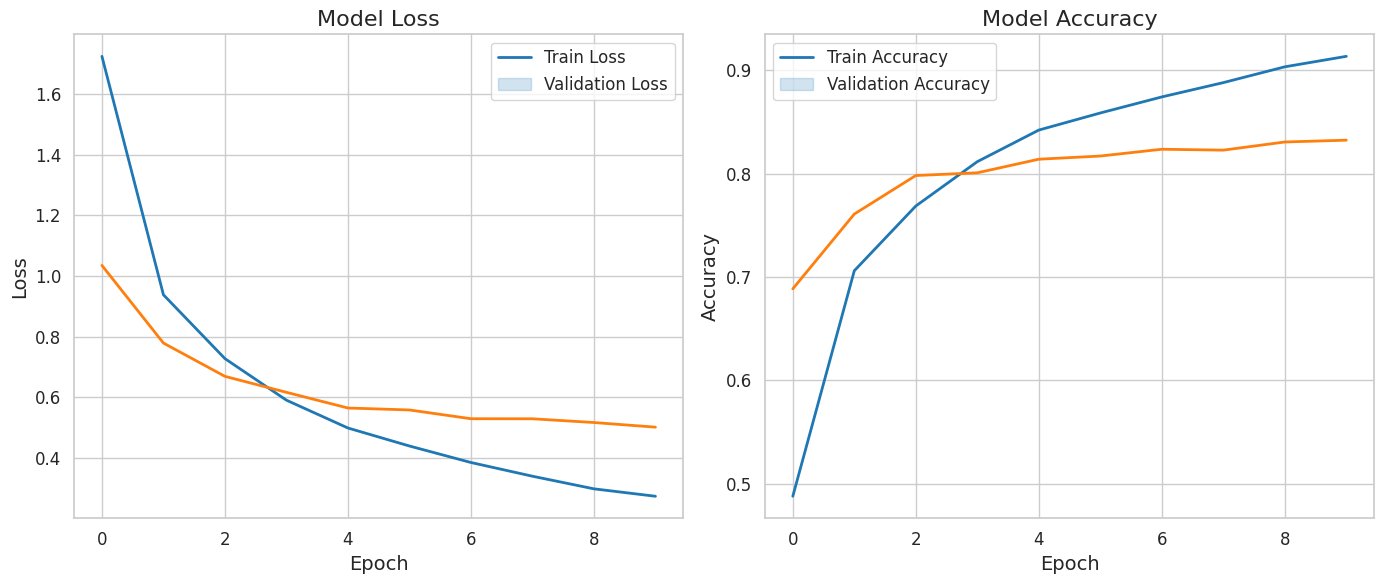

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,883 (9.89 MB)

 Trainable params: 335,387 (1.28 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.4130 - loss: 2.0464 - val_accuracy: 0.7083 - val_loss: 0.9054
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7537 - loss: 0.7782 - val_accuracy: 0.7776 - val_loss: 0.6789
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8302 - loss: 0.5536 - val_accuracy: 0.8026 - val_loss: 0.6067


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

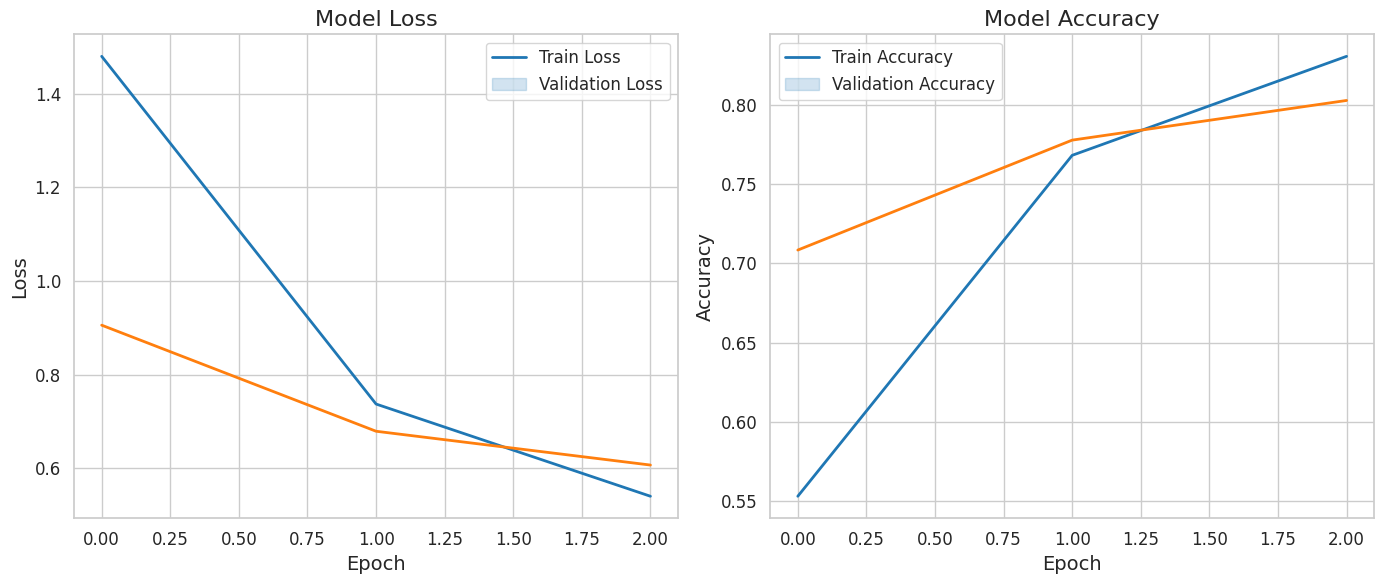

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,929,755 (11.18 MB)

 Trainable params: 670,747 (2.56 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - accuracy: 0.4772 - loss: 1.7937 - val_accuracy: 0.7224 - val_loss: 0.8305
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8020 - loss: 0.6136 - val_accuracy: 0.7925 - val_loss: 0.6302
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8748 - loss: 0.4107 - val_accuracy: 0.8285 - val_loss: 0.5349


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

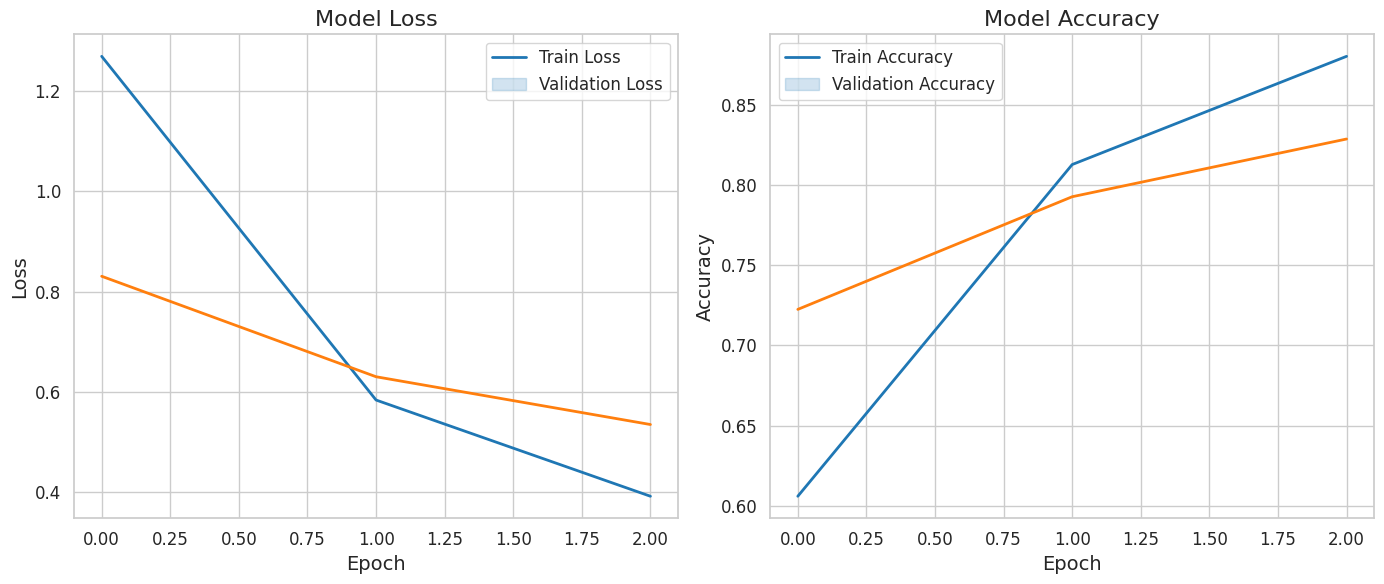

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8553 - loss: 0.4507
Test Loss: 0.45834219455718994
Test Accuracy: 0.8498136401176453


In [18]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)


# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

### Cofusion Plot

  0%|          | 0/72 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|▏         | 1/72 [00:00<00:28,  2.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 2/72 [00:00<00:17,  4.12it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 3/72 [00:00<00:13,  5.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 4/72 [00:00<00:11,  5.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 5/72 [00:00<00:10,  6.62it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 6/72 [00:01<00:09,  7.01it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 7/72 [00:01<00:08,  7.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 8/72 [00:01<00:08,  7.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▎        | 9/72 [00:01<00:08,  7.73it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 10/72 [00:01<00:07,  7.92it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 11/72 [00:01<00:07,  8.05it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 12/72 [00:01<00:07,  8.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 13/72 [00:01<00:07,  7.98it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 14/72 [00:02<00:07,  8.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 15/72 [00:02<00:06,  8.20it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 16/72 [00:02<00:07,  7.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▎       | 17/72 [00:02<00:06,  7.90it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 18/72 [00:02<00:06,  7.94it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 19/72 [00:02<00:06,  8.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 20/72 [00:02<00:06,  8.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 21/72 [00:02<00:06,  8.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 22/72 [00:02<00:05,  8.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 23/72 [00:03<00:05,  8.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 24/72 [00:03<00:05,  8.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 25/72 [00:03<00:05,  8.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 26/72 [00:03<00:05,  8.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 27/72 [00:03<00:05,  8.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 28/72 [00:03<00:05,  8.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 29/72 [00:03<00:05,  8.15it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 30/72 [00:03<00:05,  8.16it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 31/72 [00:04<00:05,  8.10it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 32/72 [00:04<00:04,  8.19it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 33/72 [00:04<00:04,  8.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 34/72 [00:04<00:04,  8.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▊     | 35/72 [00:04<00:04,  8.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 36/72 [00:04<00:04,  8.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████▏    | 37/72 [00:04<00:04,  8.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 38/72 [00:04<00:04,  8.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 39/72 [00:05<00:03,  8.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 40/72 [00:05<00:03,  8.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 41/72 [00:05<00:03,  8.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 42/72 [00:05<00:03,  8.47it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 43/72 [00:05<00:03,  8.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 44/72 [00:05<00:03,  8.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▎   | 45/72 [00:05<00:03,  8.40it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 46/72 [00:05<00:03,  8.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 47/72 [00:06<00:02,  8.42it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 48/72 [00:06<00:02,  8.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 49/72 [00:06<00:02,  8.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 50/72 [00:06<00:02,  8.39it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 51/72 [00:06<00:02,  8.44it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 52/72 [00:06<00:02,  8.59it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▎  | 53/72 [00:06<00:02,  8.70it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 54/72 [00:06<00:02,  8.51it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 55/72 [00:06<00:01,  8.63it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 56/72 [00:07<00:01,  8.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 57/72 [00:07<00:01,  8.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 58/72 [00:07<00:01,  8.50it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 59/72 [00:07<00:01,  8.57it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 60/72 [00:07<00:01,  8.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▍ | 61/72 [00:07<00:01,  8.21it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|████████▌ | 62/72 [00:07<00:01,  8.14it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 63/72 [00:07<00:01,  8.23it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 64/72 [00:08<00:00,  8.49it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|█████████ | 65/72 [00:08<00:00,  8.54it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 66/72 [00:08<00:00,  8.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 67/72 [00:08<00:00,  8.38it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 68/72 [00:08<00:00,  8.45it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 69/72 [00:08<00:00,  8.43it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 70/72 [00:08<00:00,  8.65it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▊| 71/72 [00:08<00:00,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 72/72 [00:08<00:00,  8.09it/s]


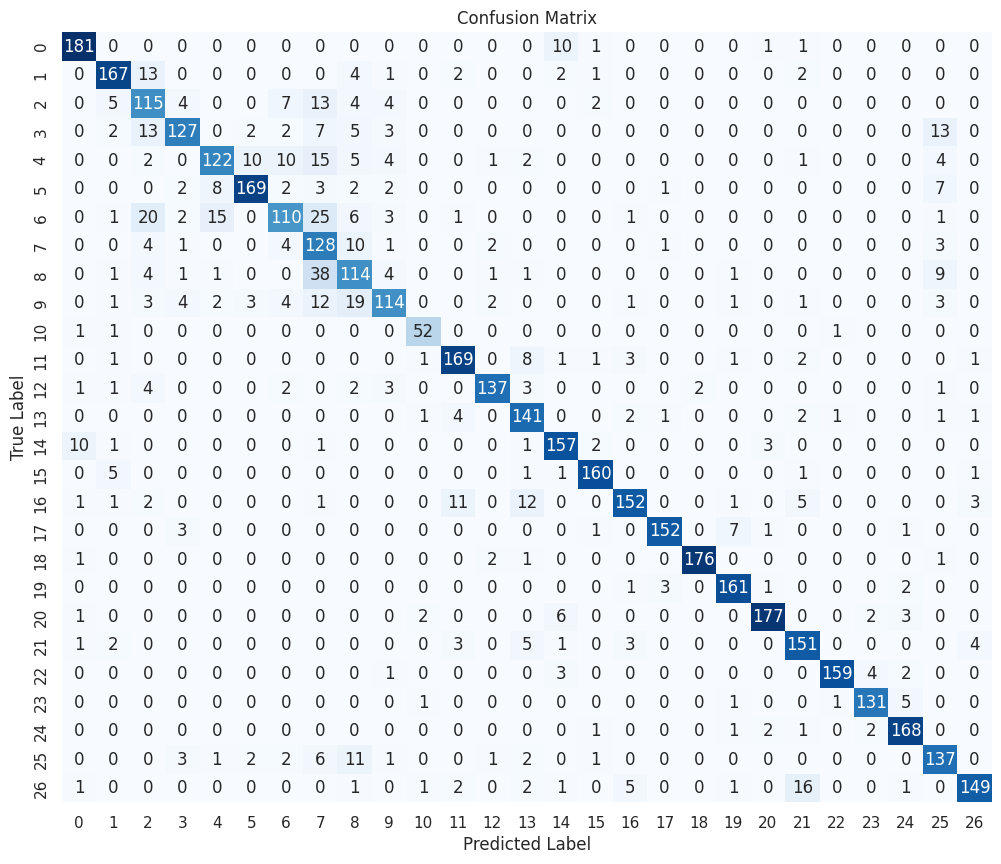

In [34]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, class_names)

## ConvNeXtBase Transfer Learning

Let's try to finetune `ConvNeXtBase` for our task.

`ConvNeXtBase` is trained on the `imagenet` dataset

---------------------------
---------------------------
HIDDEN SIZE: 128
---------------------------
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,701,659 (334.56 MB)

 Trainable params: 134,939 (527.11 KB)

 Non-trainable params: 87,566,720 (334.04 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 270s 969ms/step - accuracy: 0.2630 - loss: 2.6124 - val_accuracy: 0.5649 - val_loss: 1.6552
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 892ms/step - accuracy: 0.5974 - loss: 1.2884 - val_accuracy: 0.5890 - val_loss: 1.2292
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 891ms/step - accuracy: 0.6823 - loss: 0.9913 - val_accuracy: 0.6785 - val_loss: 1.0015
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 895ms/step - accuracy: 0.7370 - loss: 0.8282 - val_accuracy: 0.6833 - val_loss: 0.9371
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 894ms/step - accuracy: 0.7720 - loss: 0.7240 - val_accuracy: 0.6768 - val_loss: 0.9802
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 894ms/step - accuracy: 0.7906 - loss: 0.6500 - val_accuracy: 0.7202 - val_loss: 0.8341
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 893ms/step - accuracy: 0.8061 - loss: 0.5979 - val_accuracy: 0.7066 - val_loss: 0.8646
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 892ms/step - accuracy: 0.8

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

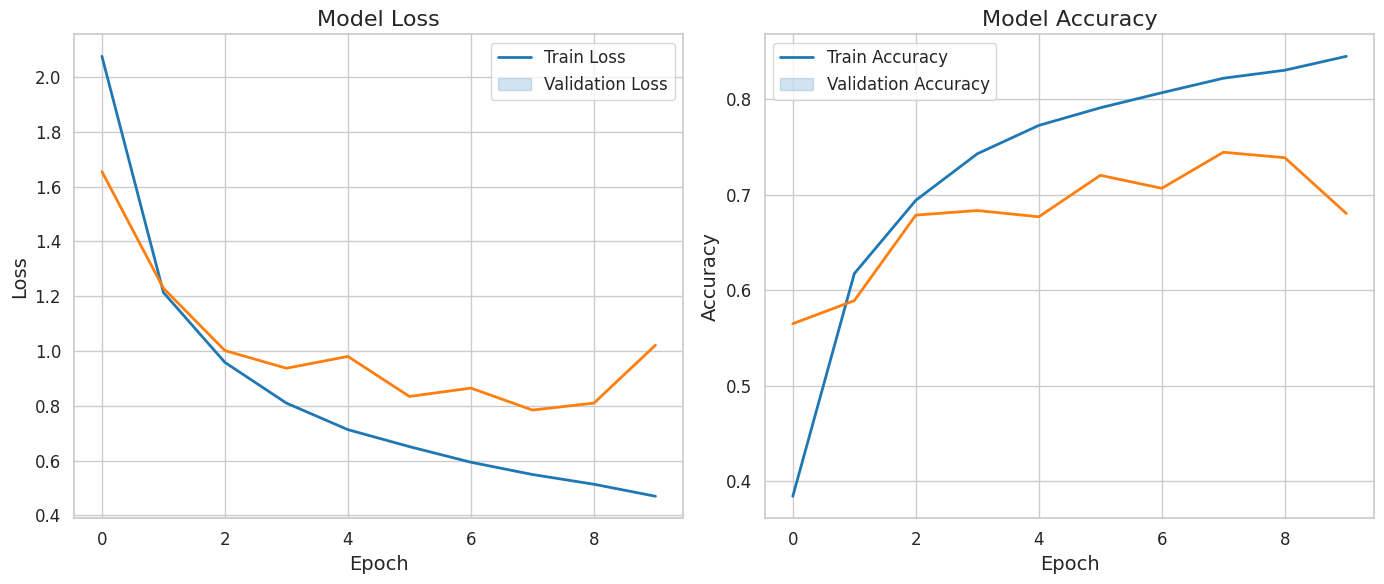

---------------------------
---------------------------
HIDDEN SIZE: 256
---------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,836,827 (335.07 MB)

 Trainable params: 269,851 (1.03 MB)

 Non-trainable params: 87,566,976 (334.04 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 256s 941ms/step - accuracy: 0.3076 - loss: 2.4130 - val_accuracy: 0.5386 - val_loss: 1.5338
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 891ms/step - accuracy: 0.6602 - loss: 1.0838 - val_accuracy: 0.6390 - val_loss: 1.0701
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 895ms/step - accuracy: 0.7459 - loss: 0.8193 - val_accuracy: 0.6298 - val_loss: 1.1055


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

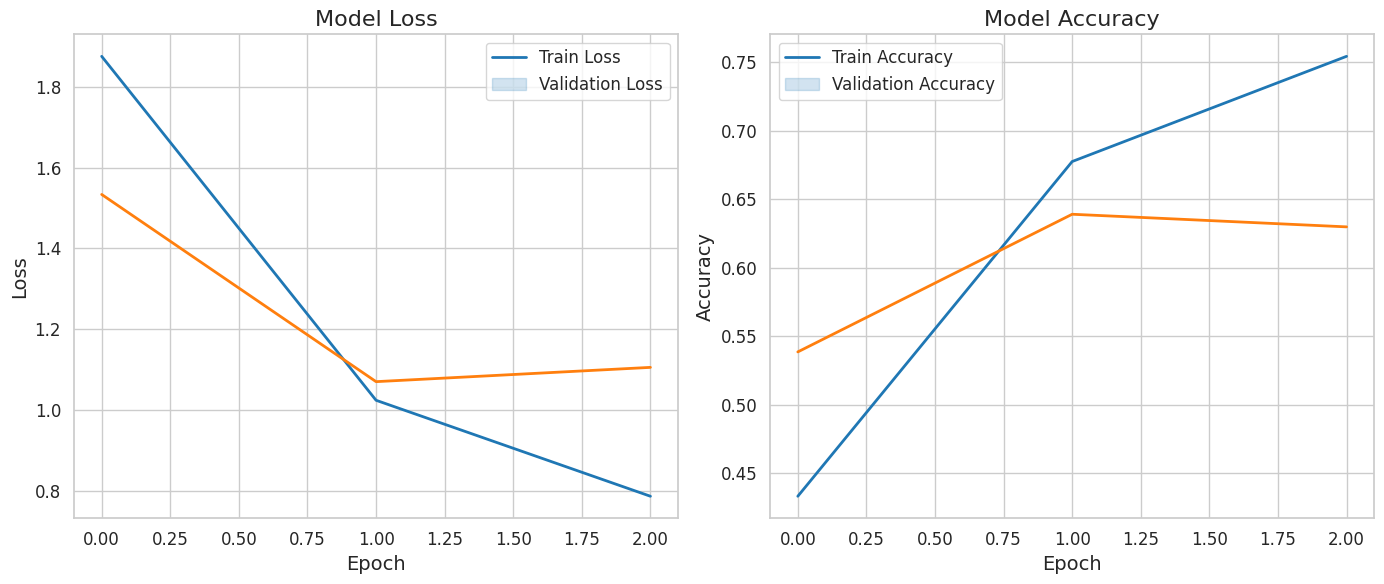

---------------------------
---------------------------
HIDDEN SIZE: 512
---------------------------


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,107,163 (336.10 MB)

 Trainable params: 539,675 (2.06 MB)

 Non-trainable params: 87,567,488 (334.04 MB)

None
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 257s 947ms/step - accuracy: 0.3599 - loss: 2.2083 - val_accuracy: 0.5149 - val_loss: 1.4820
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 222s 889ms/step - accuracy: 0.7023 - loss: 0.9208 - val_accuracy: 0.6298 - val_loss: 1.1302
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 892ms/step - accuracy: 0.7799 - loss: 0.6848 - val_accuracy: 0.6741 - val_loss: 0.9495


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

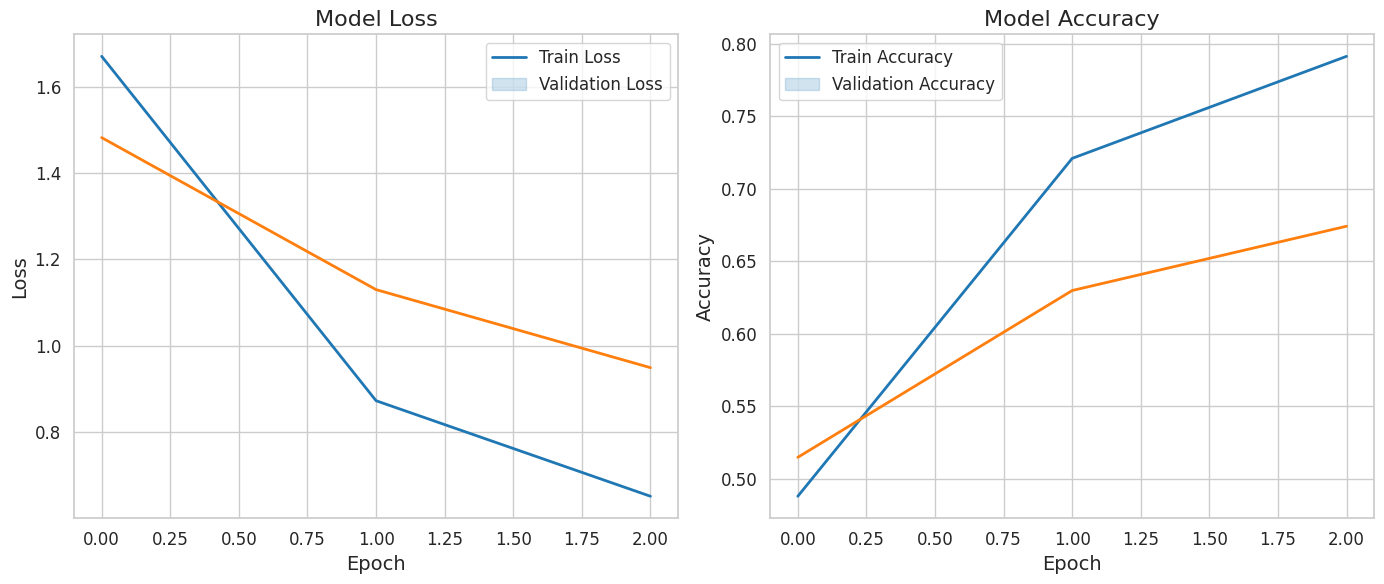

72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 826ms/step - accuracy: 0.7469 - loss: 0.7637
Test Loss: 0.78650963306427
Test Accuracy: 0.7408462762832642


In [35]:
hidden_sizes = [128, 256, 512]
best_model = None
best_acc = -1

# early stopping callback
# patience of 3 since we have a small number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

for hidden_size in hidden_sizes:

    print('---------------------------')
    print('---------------------------')
    print(f'HIDDEN SIZE: {hidden_size}')
    print('---------------------------')

    base_model = tf.keras.applications.ConvNeXtBase(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    # we dont want to train the base model
    base_model.trainable = False

    # TODO add mobilenet specific preprocessing
    
    # Add custom layers on top of the base model
    model = tf.keras.Sequential(
        [
            base_model,
            # This is added to reduce the number of parameters
            tf.keras.layers.GlobalAveragePooling2D(),
            # Add our custom hidden size
            tf.keras.layers.Dense(hidden_size, activation=None),
            # Use a batch normalization layer
            tf.keras.layers.BatchNormalization(),
            # Then the relu
            tf.keras.layers.Activation("relu"),
            # Dropout of 0.3
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(len(class_names), activation="softmax"),
        ]
    )
    
    print(model.summary())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])

    # make sure to keep the best model
    if best_model is None or history.history['val_accuracy'][-1] > best_acc:
        print('New best model found')
        best_model = model
        best_acc = history.history['val_accuracy'][-1]

    # plot two graphs, one for the train / val loss and one for the train / val accuracy
    plot_history(history)

# Finally inference with the best model
results = best_model.evaluate(test_dataset)

print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

## Confusion Matrix

  0%|          | 0/72 [00:00<?, ?it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


  1%|▏         | 1/72 [00:01<01:15,  1.06s/it]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


  3%|▎         | 2/72 [00:01<01:00,  1.17it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


  4%|▍         | 3/72 [00:02<00:55,  1.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


  6%|▌         | 4/72 [00:03<00:52,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


  7%|▋         | 5/72 [00:03<00:50,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  8%|▊         | 6/72 [00:04<00:48,  1.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 10%|▉         | 7/72 [00:05<00:47,  1.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 11%|█         | 8/72 [00:06<00:46,  1.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


 12%|█▎        | 9/72 [00:06<00:46,  1.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 14%|█▍        | 10/72 [00:07<00:45,  1.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 15%|█▌        | 11/72 [00:08<00:44,  1.37it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 17%|█▋        | 12/72 [00:09<00:43,  1.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 18%|█▊        | 13/72 [00:09<00:43,  1.36it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 19%|█▉        | 14/72 [00:10<00:42,  1.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 21%|██        | 15/72 [00:11<00:42,  1.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 22%|██▏       | 16/72 [00:12<00:41,  1.35it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 24%|██▎       | 17/72 [00:12<00:41,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 25%|██▌       | 18/72 [00:13<00:40,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 26%|██▋       | 19/72 [00:14<00:39,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 28%|██▊       | 20/72 [00:15<00:39,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 29%|██▉       | 21/72 [00:15<00:38,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 31%|███       | 22/72 [00:16<00:37,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 32%|███▏      | 23/72 [00:17<00:36,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 33%|███▎      | 24/72 [00:18<00:36,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 35%|███▍      | 25/72 [00:18<00:35,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 36%|███▌      | 26/72 [00:19<00:34,  1.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 38%|███▊      | 27/72 [00:20<00:33,  1.34it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 39%|███▉      | 28/72 [00:21<00:33,  1.33it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 40%|████      | 29/72 [00:21<00:32,  1.32it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 42%|████▏     | 30/72 [00:22<00:31,  1.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 43%|████▎     | 31/72 [00:23<00:31,  1.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 44%|████▍     | 32/72 [00:24<00:30,  1.31it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 46%|████▌     | 33/72 [00:24<00:29,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 47%|████▋     | 34/72 [00:25<00:29,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 49%|████▊     | 35/72 [00:26<00:28,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 50%|█████     | 36/72 [00:27<00:27,  1.30it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 51%|█████▏    | 37/72 [00:28<00:27,  1.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 53%|█████▎    | 38/72 [00:28<00:26,  1.29it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 54%|█████▍    | 39/72 [00:29<00:25,  1.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 56%|█████▌    | 40/72 [00:30<00:24,  1.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 57%|█████▋    | 41/72 [00:31<00:24,  1.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 58%|█████▊    | 42/72 [00:31<00:23,  1.28it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 60%|█████▉    | 43/72 [00:32<00:22,  1.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 61%|██████    | 44/72 [00:33<00:22,  1.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 62%|██████▎   | 45/72 [00:34<00:21,  1.27it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


 64%|██████▍   | 46/72 [00:35<00:20,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 65%|██████▌   | 47/72 [00:35<00:19,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 67%|██████▋   | 48/72 [00:36<00:19,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 68%|██████▊   | 49/72 [00:37<00:18,  1.26it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 69%|██████▉   | 50/72 [00:38<00:17,  1.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 71%|███████   | 51/72 [00:39<00:16,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 72%|███████▏  | 52/72 [00:39<00:16,  1.25it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 74%|███████▎  | 53/72 [00:40<00:15,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 75%|███████▌  | 54/72 [00:41<00:14,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 76%|███████▋  | 55/72 [00:42<00:13,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 78%|███████▊  | 56/72 [00:43<00:12,  1.24it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 79%|███████▉  | 57/72 [00:43<00:12,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 81%|████████  | 58/72 [00:44<00:11,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 82%|████████▏ | 59/72 [00:45<00:10,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 83%|████████▎ | 60/72 [00:46<00:09,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 85%|████████▍ | 61/72 [00:47<00:08,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 86%|████████▌ | 62/72 [00:48<00:08,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 88%|████████▊ | 63/72 [00:48<00:07,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 89%|████████▉ | 64/72 [00:49<00:06,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 90%|█████████ | 65/72 [00:50<00:05,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 92%|█████████▏| 66/72 [00:51<00:04,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 93%|█████████▎| 67/72 [00:52<00:04,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 94%|█████████▍| 68/72 [00:52<00:03,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 96%|█████████▌| 69/72 [00:53<00:02,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 97%|█████████▋| 70/72 [00:54<00:01,  1.22it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 99%|█████████▊| 71/72 [00:55<00:00,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


100%|██████████| 72/72 [00:55<00:00,  1.29it/s]


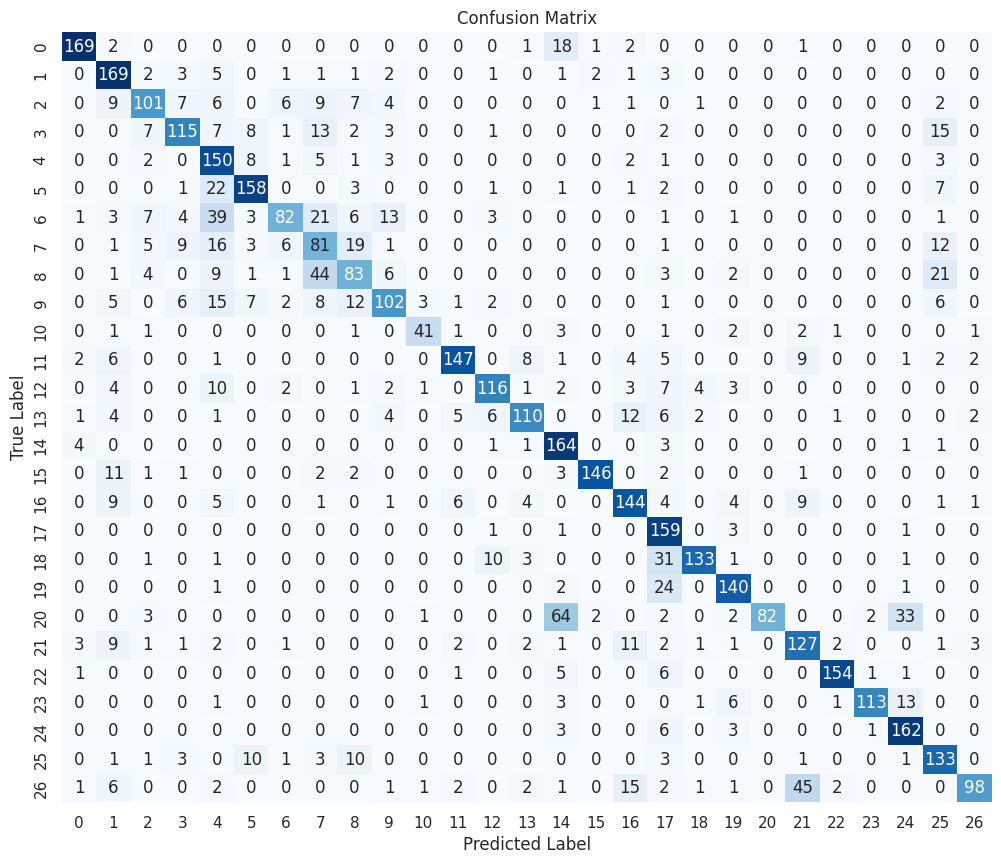

In [37]:
y_pred = []
y_true = []
for x_batch, y_batch in tqdm(test_dataset):
    y_pred_prob = best_model.predict(x_batch)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_true.extend(y_batch.numpy())

plot_confusion_matrix(y_true, y_pred, class_names)